# Investigating which areas show significant second level effects at which times

In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import source_visualisations as sv
import mne

## Data preparation
Which data?

In [2]:
# baseline [-0.3, 0], trialregs_dot=5
# basefile = 'source_HCPMMP1_allsubs_201703301614.h5'

# baseline None, trialregs_dot=5
#basefile = 'source_HCPMMP1_allsubs_201706091054.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space
#basefile = 'source_sequential_201706141650.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, sum_dot_y
#basefile = 'source_sequential_201706191442.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706201654.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706261151.h5'

# label mode = (abs)max, baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, 
# move_dist, sum_dot_y, constregs=0 for 1st dot
basefile = 'source_sequential_201706281100.h5'

choose measure and identify threshold

In [3]:
# e.g.: mu_p_large, mu_testval, mu_t, mu_mean
measure = 'mu_p_large'

# which regressors should define the empirical value distribution?
# set regressors = None for all
regressors = ['dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y']

# do not use these regressors to define empirical value distribution
exclude = 'trialregs'

# the empiric error threshold for a single time point and area
# (the selected threshold will be the quantile 1-alpha of the 
# empirical distribution of measure values)
alpha = 0.05

threshold, measure_cdf = sv.find_slabs_threshold(
    basefile, measure, quantile=1-alpha, regressors=regressors, 
    exclude=exclude, verbose=1, return_cdf=True)

print('\nthreshold = {:.4f}'.format(threshold))

excluding:
intercept
entropy
response
trial_time

adding abs_dot_x
adding abs_dot_y
adding dot_x
adding dot_y
N = 101360

threshold = 0.2660


what are large values for the possible measures (used for setting y-lim in plotting)

In [4]:
ylims = {'mu_p_large': 1, 'mu_t': 8, 'mu_z': 8, 'mu_testval': 0.02, 'mu_mean': 0.8}
logy = {'mu_p_large': False, 'mu_t': False, 'mu_z': False, 'mu_testval': True, 'mu_mean': False}

## Load data for all selected regressors and identify significant clusters in time
The idea is that you identify sequences of high measure values that cannot happen by chance. This is all based on the empirical measure distribution used above. This distribution defines the probability with which I would get a particular measure value, if I were to draw one randomly across locations, time points and regressors. So it is a permutation distribution. I then use the cumulative density function of this distribution to first select a cluster threshold, i.e., a measure value which has to be exceeded in order to form a sequence cluster. Then I identify clusters, i.e., sequences of measure values within an area that exceed the threshold. The p-value of the found cluster is the product of 1-cdf(value) for the measure values in the sequence.

In [5]:
clusters = []
for r_name in regressors:
    srcfile = basefile[:-3] + '_slabs_%s.h5' % r_name
    file = 'mne_subjects/fsaverage/bem/' + srcfile
    src_df = pd.read_hdf(file, 'second_level_src')
    clusters.append(sv.get_time_clusters(src_df[measure], threshold, measure_cdf))

clusters = pd.concat(clusters, keys=regressors, names=['regressor', 'cluster'])

now FDR-correct the found clusters

In [6]:
cluster_alpha = 0.001
reject, pval = mne.stats.fdr_correction(10**clusters.log10p, cluster_alpha)
clusters['pval_corrected'] = pval
clusters = clusters[reject]

# add region of area for information
def get_region(area):
    if area.startswith('??'):
        section = 'whole hemisphere'
    else:
        section = sv.Glasser_areas[sv.Glasser_areas['area name'] == area[2:-7]]['main section']
        section = sv.Glasser_sections.loc[section].name.values[0]
    
    return section
clusters['region'] = clusters.label.apply(get_region)

clusters.sort_values('start_t').sort_index(level='regressor', sort_remaining=False)

label  start_t  end_t    log10p  pval_corrected  \
regressor cluster                                                              
dot_x     784         R_IP0_ROI-rh      180    190 -4.805669        0.000788   
          299          L_PF_ROI-lh      180    190 -5.035585        0.000523   
          159       L_9-46d_ROI-lh      210    220 -5.011082        0.000526   
          818         R_MST_ROI-rh      240    260 -5.918910        0.000142   
          1029        R_VVC_ROI-rh      240    260 -4.878824        0.000674   
          110          L_6a_ROI-lh      250    260 -5.015923        0.000526   
          261         L_MIP_ROI-lh      280    290 -5.371928        0.000352   
          707         R_8BM_ROI-rh      290    320 -5.830001        0.000166   
          853         R_PGi_ROI-rh      290    310 -6.003580        0.000120   
          923         R_SFL_ROI-rh      300    320 -4.651896        0.000979   
          646         R_55b_ROI-rh      320    350 -6.395758        0.000075   
          52         L_31pv_ROI-lh      450    470 -5.292345        0.000375   
          741         R_AVI_ROI-rh      470    500 -7.648962        0.000011   
          632         R_47l_ROI-rh      480    500 -5.454342        0.000315   
          585         R_13l_ROI-rh      480    490 -5.343413        0.000357   
          1049     R_a9-46v_ROI-rh      490    510 -5.623489        0.000237   
          196         L_FFC_ROI-lh      550    570 -5.744074        0.000193   
          994         R_V3A_ROI-rh      550    570 -5.656410        0.000225   
          430          L_TF_ROI-lh      570    580 -5.409608        0.000329   
          221        L_IFSa_ROI-lh      610    630 -5.497098        0.000291   
          568        R_10pp_ROI-rh      630    650 -5.163240        0.000427   
          843          R_PF_ROI-rh      650    660 -6.066412        0.000113   
dot_y     676         R_V3A_ROI-rh      140    170 -7.784922        0.000011   
          198         L_OP4_ROI-lh      140    160 -5.021524        0.000526   
          540         R_IP0_ROI-rh      170    180 -5.282698        0.000375   
          246         L_Pir_ROI-lh      260    270 -5.135308        0.000444   
          99          L_8BL_ROI-lh      340    360 -5.743420        0.000193   
          265        L_SCEF_ROI-lh      400    430 -7.265922        0.000023   
          408         R_13l_ROI-rh      470    480 -5.666242        0.000225   
          451          R_6a_ROI-rh      640    650 -5.250181        0.000390   
...                            ...      ...    ...       ...             ...   
abs_dot_x 731         L_p32_ROI-lh      540    550 -5.183157        0.000426   
          1496        R_d32_ROI-rh      550    570 -6.086046        0.000111   
          212          L_9a_ROI-lh      550    570 -6.136609        0.000106   
          105          L_46_ROI-lh      560    570 -5.203205        0.000416   
          20         L_10pp_ROI-lh      560    570 -4.797271        0.000789   
          890          R_5L_ROI-rh      580    600 -5.439038        0.000320   
          1119       R_LIPv_ROI-rh      630    650 -5.057382        0.000516   
          1383         R_TF_ROI-rh      640    660 -4.770443        0.000818   
          1095        R_IP2_ROI-rh      650    650 -4.704837        0.000902   
abs_dot_y 511       L_p32pr_ROI-lh       10     20 -6.393476        0.000075   
          93          L_55b_ROI-lh       80     90 -6.792673        0.000042   
          788         R_LO3_ROI-rh      110    130 -6.560780        0.000059   
          689          R_9m_ROI-rh      130    140 -6.570195        0.000059   
          495        L_a47r_ROI-lh      130    140 -5.170324        0.000427   
          75          L_47m_ROI-lh      130    150 -5.023117        0.000526   
          70          L_47l_ROI-lh      130    150 -6.298033        0.000084   
          992          R_V2_ROI-rh      140    160 -6.152303        0.000105   
          4                 ?

In [7]:
clusters.label.groupby(level='regressor').count()

regressor
dot_x        22
dot_y         8
abs_dot_x    51
abs_dot_y    21
Name: label, dtype: int64

## Find all clusters of a given area or region

In [8]:
area = 'v23ab'
clusters[clusters.label.apply(lambda s: s.find(area) >= 0)]

,,label,start_t,end_t,log10p,pval_corrected,region
regressor,cluster,,,,,,


In [9]:
region = 'dorsolat'
clusters[clusters.region.apply(lambda s: s.find(region) >= 0)]

label  start_t  end_t    log10p  pval_corrected  \
regressor cluster                                                              
dot_x     159       L_9-46d_ROI-lh      210    220 -5.011082        0.000526   
          923         R_SFL_ROI-rh      300    320 -4.651896        0.000979   
          1049     R_a9-46v_ROI-rh      490    510 -5.623489        0.000237   
dot_y     99          L_8BL_ROI-lh      340    360 -5.743420        0.000193   
abs_dot_x 105          L_46_ROI-lh      560    570 -5.203205        0.000416   
          205          L_8C_ROI-lh      480    500 -6.349567        0.000080   
          212          L_9a_ROI-lh      550    570 -6.136609        0.000106   
          743      L_p9-46v_ROI-lh      160    180 -6.171124        0.000104   
          1014         R_9p_ROI-rh      130    150 -5.414322        0.000329   
abs_dot_y 69           L_46_ROI-lh      610    650 -9.038641        0.000002   
          523      L_p9-46v_ROI-lh      620    650 -8.034358        0.000008   
          683       R_9-46d_ROI-rh      650    660 -4.683288        0.000936   
          1047     R_a9-46v_ROI-rh      370    380 -4.795230        0.000789   

                                           region  
regressor cluster                                  
dot_x     159      dorsolateral prefrontal cortex  
          923      dorsolateral prefrontal cortex  
          1049     dorsolateral prefrontal cortex  
dot_y     99       dorsolateral prefrontal cortex  
abs_dot_x 105      dorsolateral prefrontal cortex  
          205      dorsolateral prefrontal cortex  
          212      dorsolateral prefrontal cortex  
          743      dorsolateral prefrontal cortex  
          1014     dorsolateral prefrontal cortex  
abs_dot_y 69       dorsolateral prefrontal cortex  
          523      dorsolateral prefrontal cortex  
          683      dorsolateral prefrontal cortex  
          1047     dorsolateral prefrontal cortex

## Investigate individual regressors

In [10]:
r_name = 'dot_x'
r_clusters = clusters.xs(r_name, level='regressor')

srcfile = basefile[:-3] + '_slabs_%s.h5' % r_name
file = 'mne_subjects/fsaverage/bem/' + srcfile
src_df = pd.read_hdf(file, 'second_level_src')

### Check the times at which we see significant clusters

<IPython.core.display.Javascript object>


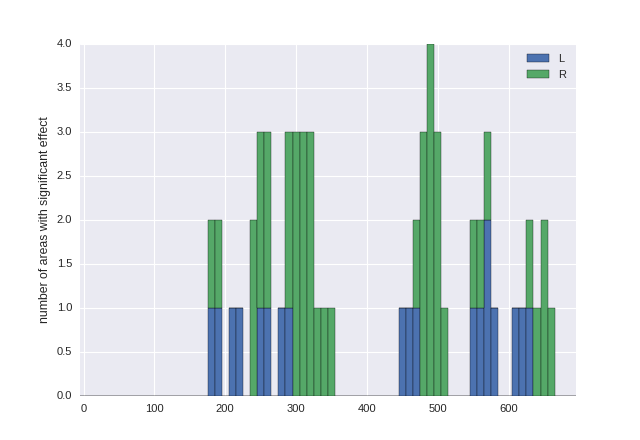

In [11]:
times = src_df[measure].index.levels[1]
sigareas = r_clusters.label.unique()
significant = pd.DataFrame(np.zeros((sigareas.size, times.size), bool), 
                           index=sigareas, columns=times)
for row in r_clusters.itertuples():
    significant.loc[row.label, slice(row.start_t, row.end_t)] = True
    
fig, ax = plt.subplots()
left = significant.columns - 5
colors = plt.rcParams['axes.prop_cycle']._left

# plot left hemi 
numlh = significant[significant.index.map(lambda l: l[0]) == 'L'].sum()
ax.bar(left, height=numlh, width=10, bottom=0, color=colors[0]['color'])
# plot right hemi
ax.bar(left, 
       height=significant[significant.index.map(lambda l: l[0]) == 'R'].sum(), 
       width=10, bottom=numlh, color=colors[1]['color'])
ax.set_ylabel('number of areas with significant effect');
ax.legend(['L', 'R']);
ax.set_xlim(left[0], left[-1]+10);

### Identify areas

In [12]:
def get_areas(times):
    if type(times) is not list:
        times = [times]
    
    return significant[np.all(significant[times], axis=1)].index

def active_areas(times, times2=None):
    """Returns areas that are reliably activated at all time points in times.
       If times2 is provided, intersection and set differences of areas 
       associated with times and times2 are indicated."""
    
    print(r_name)
    
    areas = get_areas(times)
    
    if times2 is None:
        areas2 = pd.Index([])
    else:
        areas2 = get_areas(times2)
    
    areas = pd.concat([pd.Series(areas.difference(areas2)), 
                       pd.Series(areas.intersection(areas2)), 
                       pd.Series(areas2.difference(areas))],
                      keys=['only 1', 'intersect', 'only 2'])
    areas = pd.DataFrame(areas, columns=['area'])
    
    areas['region'] = areas.area.apply(get_region)
    
    return areas

In [13]:
active_areas(140, 560)

dot_x


area                        region
only 2 0  L_FFC_ROI-lh  ventral stream visual cortex
       1  R_V3A_ROI-rh   dorsal stream visual cortex

In [14]:
active_areas(300, 490)

dot_x


area                                           region
only 1 0     R_8BM_ROI-rh  anterior cingulate and medial prefrontal cortex
       1     R_PGi_ROI-rh                         inferior parietal cortex
       2     R_SFL_ROI-rh                   dorsolateral prefrontal cortex
only 2 0     R_13l_ROI-rh                 orbital and polar frontal cortex
       1     R_47l_ROI-rh                          inferior frontal cortex
       2     R_AVI_ROI-rh             insular and frontal opercular cortex
       3  R_a9-46v_ROI-rh                   dorsolateral prefrontal cortex

In [15]:
active_areas(490, 650)

dot_x


area                                region
only 1 0     R_13l_ROI-rh      orbital and polar frontal cortex
       1     R_47l_ROI-rh               inferior frontal cortex
       2     R_AVI_ROI-rh  insular and frontal opercular cortex
       3  R_a9-46v_ROI-rh        dorsolateral prefrontal cortex
only 2 0    R_10pp_ROI-rh      orbital and polar frontal cortex
       1      R_PF_ROI-rh              inferior parietal cortex

In [16]:
active_areas(180, 660)

dot_x


area                    region
only 1 0   L_PF_ROI-lh  inferior parietal cortex
       1  R_IP0_ROI-rh  inferior parietal cortex
only 2 0   R_PF_ROI-rh  inferior parietal cortex

### Show significant clusters

In [17]:
def get_cluster_tcs(clus, baseval=0):

    mask = pd.Series(np.zeros_like(src_df[measure], dtype=bool), index=src_df[measure].index)
    for row in clus.itertuples():
        mask.loc[row.label, slice(row.start_t, row.end_t)] = True

    active = src_df[measure].where(mask, other=baseval)
    active = active.reset_index('label')
    active = active.pivot(columns='label')[measure]

    # get labels of active areas in given clusters
    maxvals = active.max()
    labels = maxvals.index[maxvals > baseval]

    # select only active areas
    active = active[labels]

    # get hemisphere of labels
    hemis = labels.map(lambda l: l[-2].upper())
    labels = labels.map(lambda l: l[2:-7])

    active.columns = pd.MultiIndex.from_arrays([hemis, labels],
                                               names=['hemi', 'label'])

    return active

### clusters from a particular region

dot_x


<IPython.core.display.Javascript object>


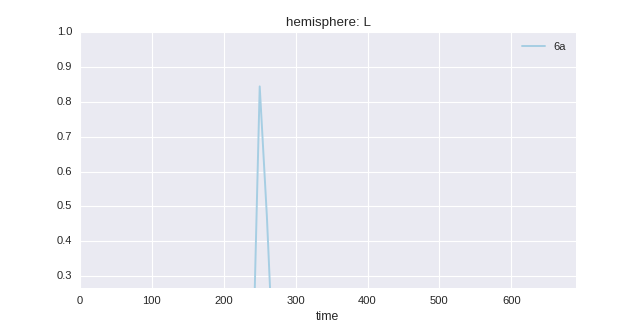

<IPython.core.display.Javascript object>


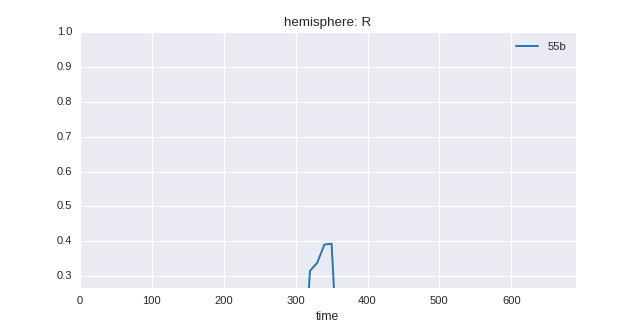

In [18]:
print(r_name)

region = 'premotor'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.region.apply(lambda s: s.startswith(region))]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters associated with a particular area

In [19]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_24dv_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

dot_x


### clusters with reliable effect around a particular time

dot_x


<IPython.core.display.Javascript object>


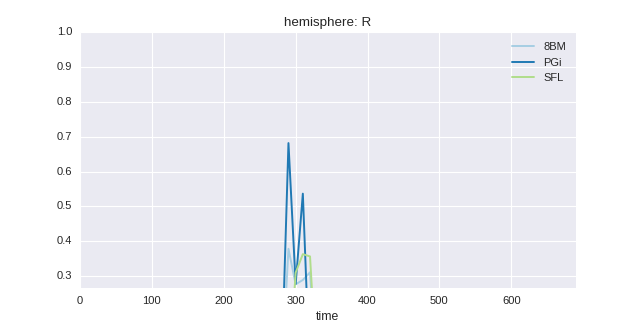

In [20]:
print(r_name)

time = 300

sv.show_timecourses(get_cluster_tcs(r_clusters[(time >= r_clusters.start_t) & (time <= r_clusters.end_t)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

In [21]:
src_df.loc[('L_46_ROI-lh', 570)]

mu_mean         0.008976
mu_std          0.005518
mu_t            1.626728
mu_testval      0.000001
mu_p_large      0.033000
sigma_mean      0.025784
sigma_std       0.003808
theta_mean      0.671776
theta_std       0.216221
lp_mean        64.453586
lp_std          1.693720
overlap        -1.010938
consistency     0.460000
Name: (L_46_ROI-lh, 570), dtype: float64